In [1]:
# Check your GPU
!nvidia-smi

Mon Apr  1 19:20:04 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090         On | 00000000:C1:00.0 Off |                  N/A |
| 30%   29C    P8               31W / 350W|      1MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Downloading Data

In [2]:
import os
import zipfile

# Install gdown (to be able to download files from Google Drive)
!pip install gdown

# Download dataset
os.makedirs('input', exist_ok=True)
path_to_dataset = "input/dataset.zip"

if not os.path.exists(path_to_dataset):
    !gdown 1Ifk07HeqxHfCCOCvb5oDF-cdxfkfsuq- -O input/dataset.zip
else:
    print(f"Already downloaded `{path_to_dataset}`")

# Unzip dataset into 'input' folder
with zipfile.ZipFile(path_to_dataset, 'r') as zip_ref:
    zip_ref.extractall('input/dataset')

# Remove zip file
os.remove(path_to_dataset)

# List input directory
%ls input/

print('Done')

Downloading...
From: https://drive.google.com/uc?id=1Ifk07HeqxHfCCOCvb5oDF-cdxfkfsuq-
To: /workspace/EveryDream2trainer/input/dataset.zip
100%|██████████████████████████████████████| 20.9M/20.9M [00:00<00:00, 62.1MB/s]
dataset/
Done


In [3]:
!wget https://raw.githubusercontent.com/learn2train/l2t-sd/main/notebooks/optimizer-photo.json

--2024-04-01 19:20:13--  https://raw.githubusercontent.com/learn2train/l2t-sd/main/notebooks/optimizer-photo.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2039 (2.0K) [text/plain]
Saving to: ‘optimizer-photo.json’

optimizer-photo.jso 100%[===================>]   1.99K  --.-KB/s    in 0s      

2024-04-01 19:20:13 (45.3 MB/s) - ‘optimizer-photo.json’ saved [2039/2039]



### Setup Wandb

In [4]:
wandb_token = "PUT-YOUR-W&B-API-KEY-HERE"
wandb_token = "3645dff2e3fa7a196b7d1f9c4fd8314def73f032"

### Inference before training

In [5]:
from diffusers import DiffusionPipeline

pipeline = DiffusionPipeline.from_pretrained("learn2train/stable-diffusion-v1-5")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

model_index.json:   0%|          | 0.00/582 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors not found


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

safety_checker/pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/520 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/346 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.91k [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

text_encoder/pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

unet/diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/582 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/workspace/venv/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [6]:
prompt = "a black and white photo of a woman wearing a floral crown and holding a bouquet of flowers in the style of Bella Kotak."

image = pipeline(prompt, num_inference_steps=30).images[0]

  0%|          | 0/30 [00:00<?, ?it/s]

### Run training

In [8]:
# Get the wandb token
wandb_settings = ""
if wandb_token:
  !rm /root/.netrc
  !wandb login $wandb_token
  wandb_settings = "--wandb"

# Start the training 
%run train.py --resume_ckpt "learn2train/stable-diffusion-v1-5" \
$wandb_settings \
--project_name "sd1_kotak" \
--data_root "input" \
--max_epochs 60 \
--sample_steps 80 \
--batch_size 6 \
--save_every_n_epochs 20 \
--zero_frequency_noise_ratio 0.04 \
--cond_dropout 0.0 \
--optimizer_config optimizer-photo.json \
--save_ckpt_dir "output"

rm: cannot remove '/root/.netrc': No such file or directory
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
** Your branch 'main' is up to date with the remote
Loading training config from None.
Error on loading training config from None.
 logging to logs/sd1_kotak-20240401-192737/sd1_kotak-20240401-192737.log
 Args:
{'amp': True,
 'aspects': [[512, 512],
             [576, 448],
             [448, 576],
             [640, 384],
             [384, 640],
             [768, 320],
             [320, 768],
             [896, 256],
             [256, 896],
             [1024, 256],
             [256, 1024]],
 'attn_type': 'sdp',
 'batch_size': 6,
 'ckpt_every_n_minutes': 1000000000.0,
 'clip_grad_norm': None,
 'clip_skip': 0,
 'cond_dropout': 0.0,
 'config': None,
 'data_root': 'input',
 'disable_amp': False,
 'disable_textenc_training': False,
 'disable_unet_training': False,
 'ema_decay_rate': None,
 'ema_device': 'cpu',
 'ema_resume_model': None,
 'ema_sample_ema_m

unet/diffusion_pytorch_model.safetensors not found
unet/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

 unet attention_head_dim: 8
Inferred yaml: v1-inference.yaml, attn: sd1, prediction_type: epsilon
* HuggingFace Downloaded model from learn2train/stable-diffusion-v1-5 to /root/.cache/huggingface/hub/models--learn2train--stable-diffusion-v1-5/snapshots/c65eab801b6c8d3407a1c6f89569d4465fc1f43f.
** Using attention yaml file: v1-inference.yaml, is_sd1_attn: True.
 * Using default (DDPM) noise scheduler for training: ddpm
* Using SDP attention *


wandb: Currently logged in as: taaha-s-bajwa. Use `wandb login --relogin` to force relogin


* DLMA resolution 512, buckets: [[512, 512], [576, 448], [448, 576], [640, 384], [384, 640], [768, 320], [320, 768], [896, 256], [256, 896], [1024, 256], [256, 1024]]
 Preloading images...


preloading: 100%|██████████| 109/109 [00:00<00:00, 8576.67it/s]

 * Found 109 files in 'input'
No plugins specified
 * DLMA initialized with 109 images.
 ** Dataset 'train': 21 batches, num_images: 126, batch_size: 6

 raw optimizer_config:
{'apply_grad_scaler_step_tweaks': True,
 'base': {'betas': [0.9, 0.999],
          'epsilon': 1e-08,
          'lr': 1e-06,
          'lr_decay_steps': None,
          'lr_scheduler': 'constant',
          'lr_warmup_steps': None,
          'optimizer': 'adamw8bit',
          'weight_decay': 0.01},
 'text_encoder_freezing': {'unfreeze_last_n_layers': 6},
 'text_encoder_overrides': {'betas': None,
                            'epsilon': None,
                            'lr': 5e-07,
                            'lr_decay_steps': None,
                            'lr_scheduler': 'cosine',
                            'lr_warmup_steps': None,
                            'optimizer': None,
                            'weight_decay': None}}
 Final unet optimizer config:
{'betas': [0.9, 0.999],
 'epsilon': 1e-08,
 'lr': 1

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 * Generating samples at gs:79 for 3 prompts


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 * Generating samples at gs:159 for 3 prompts


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 * Generating samples at gs:239 for 3 prompts


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 * Generating samples at gs:319 for 3 prompts


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 * Generating samples at gs:399 for 3 prompts


  0%|          | 0/21 [00:00<?, ?it/s]

 Saving model, 20 epochs at step 420
 * Saving diffusers model to logs/sd1_kotak-20240401-192737/ckpts/sd1_kotak-ep20-gs00420
 * Saving SD model to output/sd1_kotak-ep20-gs00420.safetensors


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 * Generating samples at gs:479 for 3 prompts


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 * Generating samples at gs:559 for 3 prompts


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 * Generating samples at gs:639 for 3 prompts


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 * Generating samples at gs:719 for 3 prompts


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 * Generating samples at gs:799 for 3 prompts


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 Saving model, 20 epochs at step 840
 * Saving diffusers model to logs/sd1_kotak-20240401-192737/ckpts/sd1_kotak-ep40-gs00840
 * Saving SD model to output/sd1_kotak-ep40-gs00840.safetensors


  0%|          | 0/21 [00:00<?, ?it/s]

 * Generating samples at gs:879 for 3 prompts


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 * Generating samples at gs:959 for 3 prompts


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 * Generating samples at gs:1039 for 3 prompts


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 * Generating samples at gs:1119 for 3 prompts


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 * Generating samples at gs:1199 for 3 prompts


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 * Saving diffusers model to logs/sd1_kotak-20240401-192737/ckpts/last-sd1_kotak-ep60-gs01260
 * Saving SD model to output/last-sd1_kotak-ep60-gs01260.safetensors
Training complete
Total training time took 20.90 minutes, total steps: 1260
Average epoch time: 0.34 minutes
 ***************************
 **** Finished training ****
 ***************************


###  Pushing Model to huggingface

In [9]:
# Log in to Hugging Face

from huggingface_hub import notebook_login, hf_hub_download
import os
notebook_login()

In [11]:
from huggingface_hub import HfApi
api = HfApi()

In [13]:
api.upload_folder(
    folder_path="logs/sd1_kotak-20240401-192737/ckpts/last-sd1_kotak-ep60-gs01260",
    repo_id="darthPanda/sd_bella_2",
    repo_type="model",
)

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/darthPanda/sd_bella_2/commit/96e3bf7e0f7f9804752c90885b5f74d9c84bd73e', commit_message='Upload folder using huggingface_hub', commit_description='', oid='96e3bf7e0f7f9804752c90885b5f74d9c84bd73e', pr_url=None, pr_revision=None, pr_num=None)

In [14]:
from diffusers import DiffusionPipeline

pipeline = DiffusionPipeline.from_pretrained("darthPanda/sd_bella_2")

model_index.json:   0%|          | 0.00/556 [00:00<?, ?B/s]

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/562 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.93k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/797 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [15]:
prompt = "a black and white photo of a woman wearing a floral crown and holding a bouquet of flowers in the style of Bella Kotak."

image = pipeline(prompt, num_inference_steps=30).images[0]

  0%|          | 0/30 [00:00<?, ?it/s]

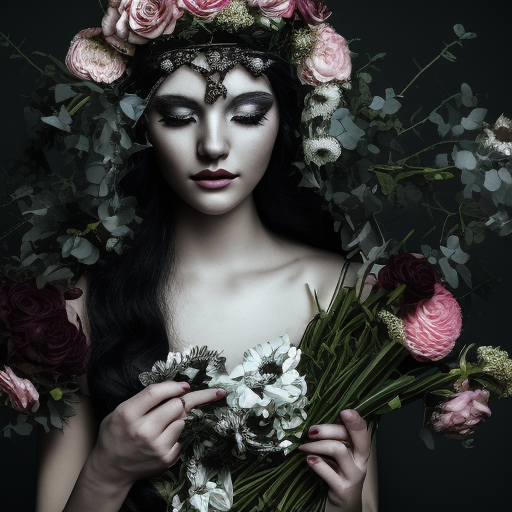

In [16]:
display(image)